In [1]:
import kinase_library as kl
testsequence='PSVEPPLsQETFSDL'

# Create a Substrate object with a target sequence (example: p53 S33)
s = kl.Substrate(testsequence)  # Lowercase 's' indicates a phosphoserine

# Predict potential kinase interactions for the substrate
s.predict()

Matplotlib is building the font cache; this may take a moment.


,Score,Score Rank,Percentile,Percentile Rank
ATM,5.0385,1,99.83,1
SMG1,4.2377,2,99.77,2
ATR,3.5045,4,99.69,3
DNAPK,3.8172,3,99.21,4
FAM20C,3.1716,5,95.23,5
...,...,...,...,...
BRAF,-4.4003,242,7.86,306
AKT2,-5.6530,284,6.79,307
P70S6KB,-3.9915,223,6.64,308
NEK3,-8.2455,310,4.85,309


In [ ]:
"""Task 1 - to write code mutating first amino acid to every other possible amino acid"""
#how to replace one letter for another in test sequence.

#how to replace one letter for each amino acid



In [2]:
mutated_sequences = [] #creates a list to store the mutated amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # defines the standard 20 amino acids
for i, original_aa in enumerate(testsequence): #indexes the original amino acids 
    for new_aa in amino_acids: #creates a loop of all amino acids
        if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] #creates a new sequence (mutated seq)
                mutated_sequences.append(mutated_seq) #stores mutated sequence

print(f'Mutated sequences (# sequences = {len(mutated_sequences)})')
print(mutated_sequences)
 #shows mutations at each position


        

Mutated sequences (# sequences = 286)
['ASVEPPLsQETFSDL', 'CSVEPPLsQETFSDL', 'DSVEPPLsQETFSDL', 'ESVEPPLsQETFSDL', 'FSVEPPLsQETFSDL', 'GSVEPPLsQETFSDL', 'HSVEPPLsQETFSDL', 'ISVEPPLsQETFSDL', 'KSVEPPLsQETFSDL', 'LSVEPPLsQETFSDL', 'MSVEPPLsQETFSDL', 'NSVEPPLsQETFSDL', 'QSVEPPLsQETFSDL', 'RSVEPPLsQETFSDL', 'SSVEPPLsQETFSDL', 'TSVEPPLsQETFSDL', 'VSVEPPLsQETFSDL', 'WSVEPPLsQETFSDL', 'YSVEPPLsQETFSDL', 'PAVEPPLsQETFSDL', 'PCVEPPLsQETFSDL', 'PDVEPPLsQETFSDL', 'PEVEPPLsQETFSDL', 'PFVEPPLsQETFSDL', 'PGVEPPLsQETFSDL', 'PHVEPPLsQETFSDL', 'PIVEPPLsQETFSDL', 'PKVEPPLsQETFSDL', 'PLVEPPLsQETFSDL', 'PMVEPPLsQETFSDL', 'PNVEPPLsQETFSDL', 'PPVEPPLsQETFSDL', 'PQVEPPLsQETFSDL', 'PRVEPPLsQETFSDL', 'PTVEPPLsQETFSDL', 'PVVEPPLsQETFSDL', 'PWVEPPLsQETFSDL', 'PYVEPPLsQETFSDL', 'PSAEPPLsQETFSDL', 'PSCEPPLsQETFSDL', 'PSDEPPLsQETFSDL', 'PSEEPPLsQETFSDL', 'PSFEPPLsQETFSDL', 'PSGEPPLsQETFSDL', 'PSHEPPLsQETFSDL', 'PSIEPPLsQETFSDL', 'PSKEPPLsQETFSDL', 'PSLEPPLsQETFSDL', 'PSMEPPLsQETFSDL', 'PSNEPPLsQETFSDL', 'PSPEPPLsQE

In [ ]:
'''
Task2 - Run these sequences through the predict function and store the output as a csv file. Look at pandas.to_csv() for this.
Output should be 280 separate csv files. Don't worry about a naming convention yet. 
'''



In [ ]:
import os
os.makedirs("mutations", exist_ok=True)
#creates a new folder called mutations to put the sequence predictions into

In [7]:
import kinase_library as kl
import pandas as pd

testsequence = 'PSVEPPLsQETFSDL'  
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
mutated_sequences = []  
wild_type_filename = f"mutations/wildtype.csv"


# Predict kinase data for the wild-type sequence
try:
    wild_type_substrate = kl.Substrate(testsequence)
    wild_type_predictions = wild_type_substrate.predict()

    # Save wild-type predictions to CSV
    df_wild_type = pd.DataFrame(wild_type_predictions)
    df_wild_type.to_csv(wild_type_filename, index=False)

    print(f"Wild-type sequence predictions saved to {wild_type_filename}")

except Exception as e:
    print(f"Error processing wild-type sequence: {e}")

for i, original_aa in enumerate(testsequence):  
    for new_aa in amino_acids:
        if new_aa != original_aa:  
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] 
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))  


print(f"Total mutations generated: {len(mutated_sequences)}") 

for i, original_aa, new_aa, mutated_seq in mutated_sequences: 
    try:
        s = kl.Substrate(mutated_seq)
        predictions = s.predict()


        df = pd.DataFrame(predictions)

        # Save to CSV file with a structured name
        filename = f"mutations/mutation_Pos{i}_{original_aa}_to_{new_aa}.csv"
        df.to_csv(filename, index=False)

    except Exception as e:
        print(f"Skipping mutation at position {i} ({original_aa} → {new_aa}): {e}")





Wild-type sequence predictions saved to mutations/wildtype.csv
Total mutations generated: 286
Skipping mutation at position 7 (s → A): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → C): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → D): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → E): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → F): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → G): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the pos

In [ ]:
'''
Task3 - Run through the 286 csv files and extract the order of the kinases. Then using the test sequence as the reference.
Compute a metric for each pair using something similar to LCS (link for inspo attached - https://chatgpt.com/share/67c705a9-9c74-8001-a8da-eac57f06384f)  
'''

In [8]:
import os
import pandas as pd
from difflib import SequenceMatcher

#This extracts the kinase orders from 269 files - one being the reference sequence.
#I assume some mutations at position 7 are skipped due to the lack of phosphoacceptor.
#So giving 18 fewer LCS scores compared to the number of CSV files generated earlier.
#This is consistent with the data shown on the heatmap in the next cell.

mut_predictions = "mutations/"

wildtype_path = os.path.join(mut_predictions, "wildtype.csv")

df_wildtype = pd.read_csv(wildtype_path)

wildtype_kinase_order = df_wildtype["Score Rank"].tolist()  #extracts kinase orders from the reference sequence

kinase_orders = {}

#reads all files to extract the kinase orders (except wildtype as that's already been done)
for file in os.listdir(mut_predictions):
    if file.endswith(".csv") and file != "wildtype.csv":
        file_path = os.path.join(mut_predictions, file)
        try:
            df = pd.read_csv(file_path)
            
            if "Score Rank" in df.columns:
                kinase_orders[file] = df["Score Rank"].tolist()  # Store kinase order
            else:
                print(f"Skipping {file}: No 'Score Rank' column found.") 
        
        except Exception as e:
            print(f"Error reading {file}: {e}")   #debugging steps

print(f"Extracted kinase orders from {len(kinase_orders)} mutation CSVs.") 

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

#finds the LCS between wildtype and mut seqs
lcs_scores = {}
for file, order in kinase_orders.items():
    lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
    lcs_scores[file] = lcs_length

#normalizes LCS scores between 0 and 1
if lcs_scores:
    lcs_min = min(lcs_scores.values())
    lcs_max = max(lcs_scores.values())

    normalized_lcs = {file: (score - lcs_min) / (lcs_max - lcs_min) for file, score in lcs_scores.items()}

   
    df_lcs = pd.DataFrame(list(normalized_lcs.items()), columns=['Mutation_File', 'Normalized_LCS'])
    
    print("\nNormalized LCS Scores:")
    print(df_lcs.sort_values(by="Normalized_LCS", ascending=True))  # Sort by lowest LCS

else:
    print("No LCS scores calculated. Ensure kinase_orders contains data.")


Extracted kinase orders from 269 mutation CSVs.

Normalized LCS Scores:
                 Mutation_File  Normalized_LCS
146   mutation_Pos2_V_to_Q.csv        0.000000
230   mutation_Pos7_s_to_Y.csv        0.006623
139   mutation_Pos2_V_to_H.csv        0.009934
263   mutation_Pos9_E_to_R.csv        0.009934
182   mutation_Pos4_P_to_N.csv        0.009934
..                         ...             ...
101  mutation_Pos14_L_to_H.csv        1.000000
102  mutation_Pos14_L_to_I.csv        1.000000
103  mutation_Pos14_L_to_K.csv        1.000000
16    mutation_Pos0_P_to_V.csv        1.000000
0     mutation_Pos0_P_to_A.csv        1.000000

[269 rows x 2 columns]


In [ ]:
'''
Task 4: generate heatmaps of LCS ratio for each mutation on the y axis and position on the x axis. I like plotly heatmaps for this
https://plotly.com/python/heatmaps/. So output will be a heat map showing hotspots for the mutations that disrup the phosphorylation motif the most
'''

In [9]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np

lcs_data = []

for file, normalized_score in normalized_lcs.items():
    
    match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

    if match:
        position = int(match.group(1)) 
        mutated_aa = match.group(2)  

        lcs_data.append([position, mutated_aa, normalized_score])


df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])


heatmap_matrix = df_lcs.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')


fig = px.imshow(
    heatmap_matrix,
    labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
    color_continuous_scale='Temps',
    title="Heatmap of LCS Ratios for Each Mutation",
)

# Format axes
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    coloraxis_colorbar=dict(
        tickvals=[0, 0.25, 0.5, 0.75, 1],  # Set scale from 0 to 1
        ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"]
    )
)
fig.show()







In [ ]:
"Generate tables and subplots showing cases for high and low LCS"

Extracted 269 mutated sequences from filenames.
Extracted kinase orders from 270 CSV files.


C:\Users\ricea\AppData\Local\Temp\ipykernel_9456\1756154341.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


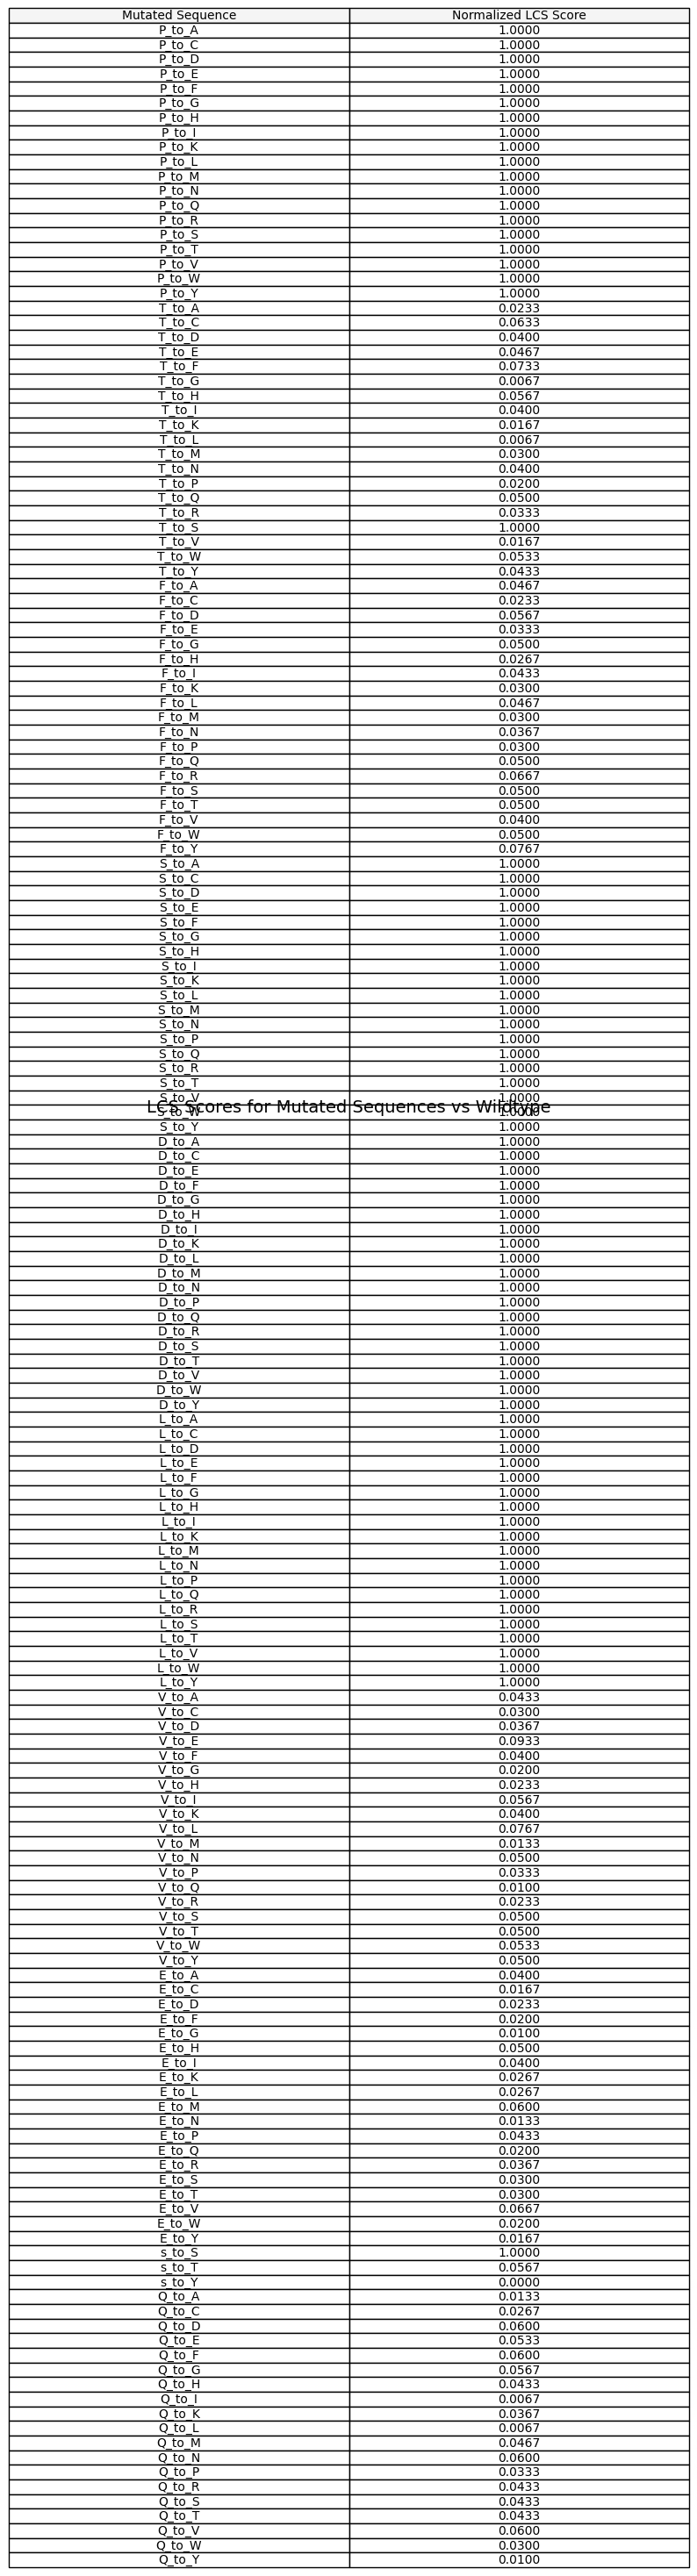

In [3]:
import os
import pandas as pd
import itertools
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

# Define paths and variables
mut_predictions = "C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project/mutations"
kinase_orders = {}
mutated_sequences = []

def extract_mutated_sequences():
    """Reads CSV files and extracts mutated sequences from the file names."""
    global mutated_sequences
    for file in os.listdir(mut_predictions):  # Finds the CSVs, reads the CSVs
        if file.endswith(".csv") and file != "wildtype.csv":  # Exclude wildtype.csv
            # Extract position, original amino acid, and new amino acid from the file name
            parts = file.split('_')
            position = parts[1]  # This is the position (i)
            original_aa = parts[2]  # This is the original amino acid
            new_aa = parts[4].split('.')[0]  # This is the new amino acid (without ".csv")
            
            # Store mutated sequence information (e.g., "P_to_A")
            mutated_sequence = f"{original_aa}_to_{new_aa}"
            mutated_sequences.append(mutated_sequence)  # Store mutated sequence

    print(f"Extracted {len(mutated_sequences)} mutated sequences from filenames.")  # Checks if it's done

def extract_kinase_orders():
    """Reads CSV files and extracts kinase orders."""
    global kinase_orders
    for file in os.listdir(mut_predictions):  # Finds the CSVs, reads the CSVs
        if file.endswith(".csv"):
            file_path = os.path.join(mut_predictions, file)
            try:
                df = pd.read_csv(file_path)

                # Check if "Score Rank" column exists
                if "Score Rank" in df.columns:
                    kinase_list = df["Score Rank"].tolist()
                    kinase_orders[file] = kinase_list  # Store kinase order for each mutation
                else:
                    print(f"Skipping {file}: No 'Score Rank' column found.")  # Proofreads

            except Exception as e:
                print(f"Error reading {file}: {e}")  # Proofreads

    print(f"Extracted kinase orders from {len(kinase_orders)} CSV files.")  # Checks if it's done

def longest_common_subsequence(seq1, seq2):
    """Computes the Longest Common Subsequence (LCS) length between two lists."""
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

def calculate_lcs_scores():
    """Calculates the LCS score between mutated sequences and wildtype sequence."""
    pairwise_lcs = {}
    
    # Wildtype sequence from the "wildtype.csv" file
    wildtype_sequence = kinase_orders.get("wildtype.csv", [])
    
    if not wildtype_sequence:
        print("Wildtype sequence not found in the kinase orders.")
        return {}

    for mutated_sequence in mutated_sequences:
        # Look up the kinase order for the mutated sequence file
        mutated_file = f"mutation_{mutated_sequence}.csv"  # Using the mutated sequence format
        mutated_order = next((order for filename, order in kinase_orders.items() if mutated_sequence in filename), None)
        
        if mutated_order:  # If mutated order is found
            lcs_length = longest_common_subsequence(wildtype_sequence, mutated_order)
            pairwise_lcs[mutated_sequence] = lcs_length
        else:
            print(f"Skipping mutated sequence: {mutated_sequence}, order not found.")
    
    # Normalize LCS scores
    lcs_scores = list(pairwise_lcs.values())
    lcs_min = min(lcs_scores)
    lcs_max = max(lcs_scores)

    # Prevent division by zero if all scores are the same
    if lcs_max - lcs_min == 0:
        print("All LCS scores are identical. Normalization skipped.")
        normalized_lcs = {seq: 1.0 for seq in pairwise_lcs}  # Assign all a score of 1
    else:
        normalized_lcs = {seq: (score - lcs_min) / (lcs_max - lcs_min) for seq, score in pairwise_lcs.items()}

    return normalized_lcs

def display_lcs_tables(normalized_lcs):
    """Displays a table for LCS scores."""
    fig, ax = plt.subplots(figsize=(10, 5))

    # Prepare the data for the table
    table_data = [(seq, f"{score:.4f}") for seq, score in normalized_lcs.items()]

    # Create a table
    table = ax.table(cellText=table_data,
                    colLabels=["Mutated Sequence", "Normalized LCS Score"],
                    loc="center",
                    cellLoc="center",
                    colColours=["#f5f5f5"] * 2)

    ax.axis("off")
    ax.set_title("LCS Scores for Mutated Sequences vs Wildtype", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example of using the functions:
# Run this once to extract mutated sequences, kinase orders, and calculate LCS scores
extract_mutated_sequences()
extract_kinase_orders()
normalized_lcs = calculate_lcs_scores()

# Then you can run the display function whenever you want to show the table
if normalized_lcs:
    display_lcs_tables(normalized_lcs)


In [ ]:
'''
Task 5. Using function below. Get a workflow up and running to ping uniprot servers, extract protein sequence 
in the format needed by kinase library to run the code on extracted sequences. You'll need to import the request library using
pip install requests
'''



In [20]:
import requests

def extract_genomic_information_from_uniprot_id(uniprot_id):
    '''
    Takes in uniprot ID as a string input and pings the Uniprot API to extract genomic coordinates of the protein and exons.
    Metadata such as name, taxID, protein sequence, genome assembly name,  ENSEMBL GeneID, ENSEMBL Transcript ID and ENSEMBL Translations IDs is included alongside the extracted coordinates.  

    Args:
    uniprot_id (str): uniprot ID

    Returns:
    genomic_information (pd.DataFrame): DataFrame containing genomic coordinates of the protein of interest alongside exon positions and metadata 
    '''
    genomic_information = pd.DataFrame()
    try:
        print(f'Searching for UniProt ID: {uniprot_id}')
        requestURL_protein = f"https://www.ebi.ac.uk/proteins/api/coordinates/{uniprot_id}"
        response_protein = requests.get(requestURL_protein, headers={"Accept": "application/json"})
        
        # Check if the request was successful
        response_protein.raise_for_status()
        
        # Load JSON response
        response_protein = response_protein.json()
        
        # Check if response is not empty
        if response_protein:
            response_protein_normalise = pd.json_normalize(
                response_protein, 
                record_path=['gnCoordinate', 'genomicLocation', 'exon'], 
                meta=['accession', 'name', 'taxid', 'sequence', 
                      ['gnCoordinate', 'genomicLocation', 'chromosome'], 
                      ['gnCoordinate', 'genomicLocation', 'start'], 
                      ['gnCoordinate', 'genomicLocation', 'end'], 
                      ['gnCoordinate', 'genomicLocation', 'reverseStrand'], 
                      ['gnCoordinate', 'genomicLocation', 'nucleotideId'], 
                      ['gnCoordinate', 'genomicLocation', 'assemblyName'], 
                      ['gnCoordinate', 'ensemblGeneId'], 
                      ['gnCoordinate', 'ensemblTranscriptId'], 
                      ['gnCoordinate', 'ensemblTranslationId']],
                record_prefix='exon_'
            )

            # Group and aggregate exon information
            response_protein_normalise = response_protein_normalise.groupby([
                'accession', 'name', 'taxid', 'sequence', 
                'gnCoordinate.genomicLocation.chromosome', 
                'gnCoordinate.genomicLocation.start', 
                'gnCoordinate.genomicLocation.end', 
                'gnCoordinate.genomicLocation.reverseStrand', 
                'gnCoordinate.genomicLocation.nucleotideId', 
                'gnCoordinate.genomicLocation.assemblyName', 
                'gnCoordinate.ensemblGeneId', 
                'gnCoordinate.ensemblTranscriptId', 
                'gnCoordinate.ensemblTranslationId'
            ]).agg({
                'exon_id': lambda x: ','.join(map(str, x)),
                'exon_proteinLocation.begin.position': lambda x: ','.join(map(str, x)),                    
                'exon_proteinLocation.end.position': lambda x: ','.join(map(str, x)),
                'exon_genomeLocation.begin.position': lambda x: ','.join(map(str, x)),                    
                'exon_genomeLocation.end.position': lambda x: ','.join(map(str, x))
            }).reset_index()

            # Concatenate to the main DataFrame
            genomic_information = pd.concat([genomic_information, response_protein_normalise], ignore_index=True)
        else:
            print(f"No data found for UniProt ID: {uniprot_id}")
            
    except Exception as e:
        print(f"An error occurred: {e}")

    return genomic_information

In [ ]:
#Example usage
test_df = extract_genomic_information_from_uniprot_id('O15533')
display(test_df)



Searching for UniProt ID: O15533


,accession,name,taxid,sequence,gnCoordinate.genomicLocation.chromosome,gnCoordinate.genomicLocation.start,gnCoordinate.genomicLocation.end,gnCoordinate.genomicLocation.reverseStrand,gnCoordinate.genomicLocation.nucleotideId,gnCoordinate.genomicLocation.assemblyName,gnCoordinate.ensemblGeneId,gnCoordinate.ensemblTranscriptId,gnCoordinate.ensemblTranslationId,exon_id,exon_proteinLocation.begin.position,exon_proteinLocation.end.position,exon_genomeLocation.begin.position,exon_genomeLocation.end.position
0,O15533,TPSN_HUMAN,9606,MKSLSLLLAVALGLATAVSAGPAVIECWFVEDASGKGLAKRPGALL...,6,33314041,33301763,True,CM000668.2,GRCh38,ENSG00000231925,ENST00000434618,ENSP00000395701,"ENSE00003898774,ENSE00003482532,ENSE0000352558...","1,13,70,157,290,404,434,446","13,70,157,290,404,434,445,448","33314041,33313864,33313477,33305387,33304638,3...","33314005,33313694,33313217,33304989,33304297,3..."
1,O15533,TPSN_HUMAN,9606,MKSLSLLLAVALGLATAVSAGPAVIECWFVEDASGKGLAKRPGALL...,HSCHR6_MHC_MCF_CTG1,4749975,4737699,True,GL000254.2,GRCh38,ENSG00000206208,ENST00000383066,ENSP00000372543,"ENSE00001941896,ENSE00003653305,ENSE0000364644...","1,13,70,157,290,404,434,446","13,70,157,290,404,434,445,448","4749975,4749798,4749411,4741323,4740574,474015...","4749939,4749628,4749151,4740925,4740233,474006..."
